In [1]:
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
"""
@File    ：PressureLocationProcess.py
@Author  ：zhaolin
@Date    ：2022/3/31 14:35
"""
import os
from math import tan
from typing import Any, Tuple

import cv2
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
import abc


def imwrite(filename, file):
    dir = os.path.join(os.getcwd(), 'res')
    if not os.path.exists(dir):
        os.makedirs(dir)
    cv2.imwrite(os.path.join(dir, filename), file)

class BaseImageProcess(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def process_image(self, image: ndarray) -> Tuple[ndarray, Any]:
        """
        :param image: 读入的图片
        :return: 第一个返回值是处理后的图片，第二个返回值是额外的信息，包括异常的位置、轮廓(如果有)等信息
        """
        pass

# 计算两点之间的距离
def calculate_distance(point1, point2):
    """
    计算两点之间的距离
    :param point1:
    :param point2:
    :return:
    """
    return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** 0.5

class PressureLocationProcess(BaseImageProcess):
    def __init__(self, filename):
        self.filename = filename
        global raw_filename
        raw_filename = filename.split('.')[0]

    def cut_image(self, image: ndarray) -> Tuple[ndarray, ndarray, tuple]:
        """
        输入一张图片，切割出压线筒区域，返回切割后的图片和边缘的坐标
        :param image:
        :return:
        """
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lower_blue = np.array([100, 43, 46])
        upper_blue = np.array([124, 255, 255])
        mask = cv2.inRange(hsv, lower_blue, upper_blue)
        img_morph = mask.copy()
        core = (3, 3)
        cv2.erode(img_morph, core, img_morph, iterations=16)
        cv2.dilate(img_morph, core, img_morph, iterations=2)
        # 中值滤波
        img_morph = cv2.medianBlur(img_morph, 15)
        # 获取面积最大的轮廓 ，这个轮廓是除了物体的区域
        res = cv2.findContours(img_morph, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        cnts = res[0]
        cnts_sort = sorted(cnts, key=cv2.contourArea, reverse=True)
        # 搞一个白底的图，然后把轮廓区域填充黑色
        white_image = np.zeros(image.shape, np.uint8)
        white_image[:, :, :] = 255
        cv2.drawContours(white_image, cnts_sort, 0, (0, 0, 0), -1)
        white_image = cv2.cvtColor(white_image, cv2.COLOR_BGR2GRAY)
        object_edge = cv2.findContours(white_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        img_copy = image.copy()
        # 用绿色圈出轮廓
        cv2.drawContours(img_copy, object_edge[0][0], -1, (0, 255, 0), 10)
        imwrite('img_green_edge.png', img_copy)
        image = self.fill_outside_black(image, object_edge[0][0])
        # 用方框裁出来
        x, y, w, h = cv2.boundingRect(object_edge[0][0])
        pure_img = image.copy()
        # 获得方框
        cv2.rectangle(pure_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        imwrite('pure_img.png', pure_img)
        # 裁剪
        cuted_image = image[y:y + h, x:x + w]
        imwrite('cuted_image.png', cuted_image)
        bounding = res[0][0]

        # 裁剪后边缘需要移动到图片上
        def bounding_move(bounding_point):
            bounding_point[0, 0] -= x
            bounding_point[0, 1] -= y
            return bounding_point

        bounding = np.array(list(map(bounding_move, bounding)))
        return cuted_image, bounding, (x, y)

    def fill_inside_black(self, image, bounding):
        """
        把边缘以内的区域填充黑色
        :param image:
        :param bounding:
        :return:
        """
        stencil = np.zeros(image.shape).astype(image.dtype)
        stencil[:, :, :] = 255
        color = (0, 0, 0)
        cv2.fillPoly(stencil, [bounding], color)
        result = cv2.bitwise_and(image, stencil)
        return result

    def fill_outside_black(self, image, bounding):
        """
        把边缘以外的区域填充黑色
        :param image:
        :param bounding:
        :return:
        """
        stencil = np.zeros(image.shape).astype(image.dtype)
        stencil[:, :, :] = 0
        color = (255, 255, 255)
        cv2.fillPoly(stencil, [bounding], color)
        result = cv2.bitwise_and(image, stencil)
        return result

    def cut_cone(self, image: ndarray):
        """
        把线芯给去掉
        TODO 这里的参数还是得调整，这里会把露出的线芯也包含进去
        :param image:
        :return:
        """
        OLD_IMG = image.copy()

        imwrite('old_img.png', OLD_IMG)
        gray_old_img = cv2.cvtColor(OLD_IMG, cv2.COLOR_BGR2GRAY)
        imwrite('gray_old_img.png', gray_old_img)
        # TODO 这里的参数要调整
        high_brightness = self.change_brightness_and_contrast(gray_old_img, 0, 250)
        imwrite('high_brightness.png', high_brightness)
        # TODO 这里的参数要调整
        ret, thresh1 = cv2.threshold(high_brightness, 120, 255, cv2.THRESH_BINARY)
        imwrite('thresh1.png', thresh1)
        core = (3, 3)
        cv2.erode(thresh1, (2, 2), thresh1, iterations=10)
        imwrite('erode.png', thresh1)
        cv2.dilate(thresh1, (4, 4), thresh1, iterations=25)
        imwrite('dilate.png', thresh1)
        res = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        cnts_sort = sorted(res[0], key=cv2.contourArea, reverse=True)
        # cnts_sort[0] 就是线材的边缘
        cv2.drawContours(OLD_IMG, cnts_sort, 0, (0, 0, 255), -1)
        imwrite('old_img2.png', OLD_IMG)

        """
        以上操作再提供一种思路，先用简单方法，把线材的大概区域找出来，不用特别精细，然后找到改区域的中间一个像素
        然后使用floodfill()方法（类似ps里面的魔棒工具）获取线材区域
        好像效果也一般
        """
        # 接下来把线材搞掉
        # 思路是 先找一个最小矩形，然后框起来，然后沿着短边把图像的一半涂成黑色
        _, box, _, boxed_line_image = self.minRect(image, cnts_sort[0])
        imwrite('boxed_line_image.png', boxed_line_image)

        def extend_short_edge(raw_box: ndarray):
            line1 = calculate_distance(raw_box[0], raw_box[1])
            line2 = calculate_distance(raw_box[1], raw_box[2])
            if line1 < line2:
                # 说明box[0]-raw_box[1]是短边
                short1 = [raw_box[0], raw_box[1]]
                short2 = [raw_box[2], raw_box[3]]
            else:
                # 说明box[1]-raw_box[2]是短边
                short1 = [raw_box[1], raw_box[2]]
                short2 = [raw_box[0], raw_box[3]]

            extend_short1 = [[2 * short1[1][0] - short1[0][0], 2 * short1[1][1] - short1[0][1]],
                             [2 * short1[0][0] - short1[1][0], 2 * short1[0][1] - short1[1][1]]]
            extend_short2 = [[2 * short2[0][0] - short2[1][0], 2 * short2[0][1] - short2[1][1]],
                             [2 * short2[1][0] - short2[0][0], 2 * short2[1][1] - short2[0][1]]]
            extend_box = extend_short1 + extend_short2
            return np.array(extend_box)

        extend_box = extend_short_edge(box)
        image_copy = image.copy()
        cv2.drawContours(image_copy, [extend_box], 0, (255, 255, 255), 1)
        imwrite('extend_boxed_image.png', image_copy)
        cv2.drawContours(image, [extend_box], 0, (0, 0, 0), -1)
        # 这里需要把线芯搞出来
        # mask = np.zeros(image.shape[:2], np.uint8)
        # SIZE = (1, 65)
        # bgdModle = np.zeros(SIZE, np.float64)
        # fgdModle = np.zeros(SIZE, np.float64)
        # rect = (1, 1, image.shape[1], image.shape[0])
        # # TODO 这个函数不稳定
        # cv2.grabCut(image, mask, rect, bgdModle, fgdModle, 10, cv2.GC_INIT_WITH_RECT)
        # mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
        # image *= mask2[:, :, np.newaxis]

        # 这是裁剪后的结果
        imwrite('image_remove_line.png', image)

        def find_cone(cuted_cone):
            gray_cuted_cone = cv2.cvtColor(cuted_cone, cv2.COLOR_BGR2GRAY)
            res = cv2.findContours(gray_cuted_cone, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            cnts = res[0]
            cnts_sort = sorted(cnts, key=cv2.contourArea, reverse=True)
            # cv2.drawContours(cuted_cone, cnts_sort, 0, (0, 0, 255), 2)
            imwrite('cuted_cone.png', cuted_cone)
            black_img = np.zeros_like(cuted_cone)
            black_img[:, :, :] = 0
            cv2.drawContours(black_img, cnts_sort, 0, (255, 255, 255), -1)
            imwrite('black_img.png', black_img)
            black_img = cv2.cvtColor(black_img, cv2.COLOR_BGR2GRAY)
            cone = cv2.add(cuted_cone, np.zeros(np.shape(cuted_cone), dtype=np.uint8), mask=black_img)
            imwrite('cone.png', cone)
            return cone, cnts_sort[0]

        cone, edge = find_cone(image)
        return cone, edge

    def minRect(self, image, edge):
        """
        根据边缘拿到最小矩形
        :param image:
        :param edge:
        :return:
        """
        rect = cv2.minAreaRect(edge)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        image_copy = image.copy()
        cv2.drawContours(image_copy, [box], 0, (255, 255, 255), 1)
        imwrite('boxed_image.png', image_copy)
        return image, box, rect, image_copy

    def rotate_image(self, image, box, rect):
        """
        旋转图像
        :param image:
        :param box:
        :param rect:
        :return:
        """
        center, size, angle = rect[0], rect[1], rect[2]
        center, size = tuple(map(int, center)), tuple(map(int, size))
        if size[0] < size[1]:
            angle -= 270
            w = size[1]
            h = size[0]
        else:
            w = size[0]
            h = size[1]
        size = (w, h)
        height, width = image.shape[0], image.shape[1]
        M = cv2.getRotationMatrix2D(center, angle, 1)
        image_rot = cv2.warpAffine(image, M, (width, height))
        imwrite('image_rot.png', image_rot)
        image_crop = cv2.getRectSubPix(image_rot, size, center)
        imwrite('image_crop.png', image_crop)
        return image_crop

    def change_brightness_and_contrast(self, image, brightness, contrast):
        """
        修改图像的亮度和对比度
        :param image:
        :param brightness:
        :param contrast:
        :return:
        """

        def clip_range(value, min=0, max=255):
            return max if value > max else (min if value < min else value)

        brightness = clip_range(brightness, -255, 255)
        contrast = clip_range(contrast, -255, 255)
        B = brightness / 255
        c = contrast / 255
        k = tan((45 + 44 * c) / 180 * np.pi)
        table = np.array([clip_range((i - 127.5 * (1 - B)) * k + 127.5 * (1 + B)) for i in range(0, 256)]).clip(0, 255). \
            astype('uint8')
        lut_out = cv2.LUT(image, table)
        imwrite('lut_out.png', lut_out)
        return lut_out

    def get_main_area(self, image, lut_out):
        """
        获取主要的压接那一半
        :param image:
        :param lut_out:
        :return:
        """
        lut_out_gray = cv2.cvtColor(lut_out, cv2.COLOR_BGR2GRAY)
        imwrite('lut_out_gray.png', lut_out_gray)
        cv2.dilate(lut_out_gray, np.ones((3, 3), np.uint8), lut_out_gray, iterations=3)
        edge = self.find_rand_n_area_edge(lut_out_gray, 0)
        image = image.copy()
        # cv2.drawContours(image, [edge], 0, (0, 0, 255), 2)
        imwrite('max_edge.png', image)
        image, box, rect, image_copy = self.minRect(image, edge)
        image_main = self.fill_outside_black(lut_out, box)

        imwrite('image_main_before_rotate.png', image_main)
        image_main = self.rotate_image(image_main, box, rect)
        imwrite('image_main_after_rotate.png', image_main)
        return image_main

    def find_rand_n_area_edge(self, image, n=0):
        """
        拿面积第n大的边缘
        :param image:
        :param n:
        :return:
        """
        res = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        cnts = res[0]
        cnts_sort = sorted(cnts, key=cv2.contourArea, reverse=True)
        return cnts_sort[n]

    def get_measure_area(self, main_area):
        main_area_copy = main_area.copy()
        gray_main_area = cv2.cvtColor(main_area_copy, cv2.COLOR_BGR2GRAY)
        cv2.dilate(gray_main_area, np.ones((3, 3), np.uint8), gray_main_area, iterations=1)
        imwrite('main_area_after_dilate.png', gray_main_area)
        cv2.threshold(gray_main_area, 50, 255, cv2.THRESH_BINARY, gray_main_area)
        imwrite('main_area_after_threshold.png', gray_main_area)
        # not_gray_main_area = cv2.bitwise_not(gray_main_area)
        # imwrite('not_gray_main_area.png', not_gray_main_area)
        # cv2.threshold(not_gray_main_area, 150, 255, cv2.THRESH_BINARY, not_gray_main_area)
        # imwrite('not_gray_main_area_after_threshold.png', not_gray_main_area)
        edge = self.find_rand_n_area_edge(gray_main_area, 0)
        cv2.drawContours(main_area_copy, [edge], 0, (0, 0, 255), 1)
        imwrite('max_area_main.png', main_area_copy)
        black_img = np.zeros(main_area.shape, dtype=main_area.dtype)
        cv2.drawContours(black_img, [edge], 0, (255, 255, 255), -1)
        imwrite('main_area_black_img.png', black_img)
        return black_img

    def plot_by_axis(self, image, axis, step=1):
        """
        统计 axis 轴的像素分布
        :param step: 步长，默认为1
        :param image: 图像
        :param axis: 0是x轴，1是y轴
        :return:
        """
        image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
        if axis == 0:
            image_shape = image.shape[1]
        elif axis == 1:
            image_shape = image.shape[0]
        else:
            exit('axis must be 0 or 1')
            return
        sum_step = ceil(image_shape / step)
        hist = []
        for i in range(sum_step):
            if axis == 0:
                hist.append(np.sum(image[:, i * step:(i + 1) * step]))
            else:
                hist.append(np.sum(image[i * step:step * (i + 1), :]))
        plt.figure()
        plt.plot(hist)
        plt.show()
        return hist

    def find_top_or_bottom_pixel(self, image, location):
        """
        找到图像的顶部或者底部的像素
        :param image:
        :param location: 0为顶部，1为底部
        :return:
        """
        image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
        if location == 0 or location == 1:
            height, width = image.shape
        else:
            exit('location must be 0 or 1')
            return
        points = []
        if location == 0:
            for i in range(width):
                for j in range(height):
                    if image[j, i] == 255:
                        points.append([i, j])
                        break
        elif location == 1:
            for i in range(width):
                for j in range(height - 1, -1, -1):
                    if image[j, i] == 255:
                        points.append([i, j])
                        break
        points = np.array(points)
        plt.figure()
        plt.plot(points[:, 0], points[:, 1])
        plt.show()
        return points

    def process_image(self, image: ndarray) -> Tuple[ndarray, Any]:
        cut_image, bounding, (x, y) = self.cut_image(image)
        fill_black = self.fill_inside_black(cut_image, bounding)
        image, edge = self.cut_cone(fill_black)
        image, box, rect, image_copy = self.minRect(image, edge)
        imwrite('image_after_minRect.png', image_copy)
        image = self.rotate_image(image, box, rect)
        lut_out = self.change_brightness_and_contrast(image, -150, 250)
        main_area = self.get_main_area(image, lut_out)

def cv_show(img):
    cv2.imshow('cv_show', img)
    cv2.waitKey(0)  # 等待时间，毫秒级，0标示按任意键终止
    cv2.destroyAllWindows()
    cv2.waitKey(1)  # 解决mac中窗口不关闭的问题
    
def showImages(images, titles = [''], size = [1, 1], BGR = False):
    for i in range(len(images)):
        plt.subplot(size[0], size[1], i + 1)
        showImage = images[i]
        if (BGR):
            b,g,r = cv2.split(images[i])
            showImage = cv2.merge([r,g,b])
        plt.imshow(showImage ,'gray')
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])

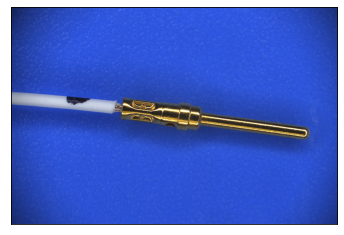

In [2]:
imgPath = "/Users/zhouxinyu/Code/Python/jupyter/Project/ZF/数据测试/绝缘层污染损伤/数据/污染2/21.jpg"
img = cv2.imread(imgPath, cv2.IMREAD_COLOR)
pp = PressureLocationProcess(imgPath)
pp.process_image(img)
showImages([img], BGR=True)